In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import ast
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

%load_ext lab_black

## Data Loading and formatting

In [2]:
# Dataset:
"https://www.kaggle.com/code/artgor/object-detection-with-pytorch-lightning"

'https://www.kaggle.com/code/artgor/object-detection-with-pytorch-lightning'

In [3]:
# DIR_INPUT = '/kaggle/input/global-wheat-detection'
TRAIN_DIR = f"../data/wheat/train"
TEST_DIR = f"../data/wheat/test/"

In [28]:
df = pd.read_csv("../data/wheat/train.csv")

In [5]:
df.tail()

,image_id,width,height,bbox,source
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2
147792,5e0747034,1024,1024,"[875.0, 740.0, 94.0, 61.0]",arvalis_2


In [6]:
def PIL_read(path: str) -> np.ndarray:
    img = Image.open(path)
    img = np.asarray(img)
    return img

### Train/Validate Split

In [7]:
image_list = df["image_id"].unique()
image_list.size

3373

In [8]:
valid_image_list = image_list[-round(3373 * 0.2) :]
train_image_list = image_list[: -round(3373 * 0.2)]
print(
    f"{len(train_image_list)} training images and {len(valid_image_list)} validation images"
)

2698 training images and 675 validation images


In [9]:
train_paths = [
    os.path.join(TRAIN_DIR, f"{filename}.jpg") for filename in train_image_list
]
valid_paths = [
    os.path.join(TRAIN_DIR, f"{filename}.jpg") for filename in valid_image_list
]
train_images = [PIL_read(f) for f in train_paths]
valid_images = [PIL_read(f) for f in valid_paths]

#### Plot some samples

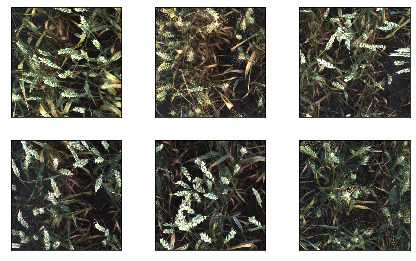

In [10]:
fig = plt.figure()
for i, random_num in enumerate([np.random.randint(1, 200) for x in range(6)]):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(train_images[random_num], cmap="gray", interpolation="none")
    plt.xticks([])
    plt.yticks([])

### Bounding boxes

In [11]:
df["bbox"]

0          [834.0, 222.0, 56.0, 36.0]
1         [226.0, 548.0, 130.0, 58.0]
2         [377.0, 504.0, 74.0, 160.0]
3         [834.0, 95.0, 109.0, 107.0]
4         [26.0, 144.0, 124.0, 117.0]
                     ...             
147788      [64.0, 619.0, 84.0, 95.0]
147789    [292.0, 549.0, 107.0, 82.0]
147790    [134.0, 228.0, 141.0, 71.0]
147791     [430.0, 13.0, 184.0, 79.0]
147792     [875.0, 740.0, 94.0, 61.0]
Name: bbox, Length: 147793, dtype: object

In [32]:
df["bbox"] = (
    df["bbox"].str.replace("[", "", regex=False).str.replace("]", "", regex=False)
)
df[["x", "y", "w", "h"]] = (
    df["bbox"].str.split(",", expand=True).apply(pd.to_numeric, errors="coerce")
)

In [35]:
df.drop(columns="bbox", inplace=True)

In [36]:
df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [ ]:
fig = plt.figure()
# for i, random_num in enumerate([np.random.randint(1, 200) for x in range(6)]):
#     image = train_images[random_num]
#     plt.subplot(2, 3, i + 1)
#     plt.tight_layout()
#     plt.imshow(image, cmap="gray", interpolation="none")
#     cv2.rectangle(image, )
#     plt.xticks([])
#     plt.yticks([])

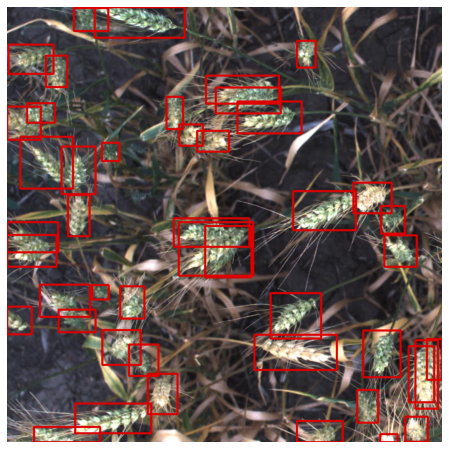

In [51]:
image = train_images[1]
image_id = image_list[1]
boxes = df[df["image_id"] == image_id][["x", "y", "w", "h"]].astype(int).values
boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
# for box in boxes:
#     print(box)
#     print(box[0])
#     print(type(box[0]))
#     cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (220, 0, 0), 3)
#     break
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
for box in boxes:
    cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (220, 0, 0), 3)

ax.set_axis_off()
ax.imshow(image)